In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Read Data**

In [ ]:
import pandas as pd

In [ ]:
news_train=pd.read_excel('/content/drive/MyDrive/News_train.xlsx')

In [ ]:
news_train.shape

(5000, 2)

# **Preprocessing**

### **re**

In [ ]:
!pip install pyarabic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pyarabic

In [ ]:
import re
import unicodedata
from pyarabic.araby import tokenize

def normalize_arabic(text):
    # Normalize Arabic text
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn') # remove diacritics
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub('/', ' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub('_', ' ', text)
    text = re.sub(' و ', ' ', text)
    text = re.sub("'", ' ', text)
    text = re.sub("``", ' ', text)
    text = re.sub('"', ' ', text)
    text = re.sub('%', ' ', text)
    text = re.sub('»', ' ', text)
    text = re.sub('«', ' ', text)
    text = re.sub(r'\bال(\w+)\b', r'\1', text)
    text = re.sub(r'\bلل(\w+)\b', r'\1', text)
    text = re.sub(r'\bبال(\w+)\b', r'\1', text)
    text = re.sub(r'[A-Za-z0-9]', r'', text)#remove english characters
    text = re.sub(r'[0-9]', r'', text)#remove numbers
    text = re.sub(r'[^\w\s]', r'', text)#remove punctuation

    words = tokenize(text)

    normalized_text = ' '.join(words)

    return normalized_text

In [ ]:
news_train['News'] = news_train['News'].apply(normalize_arabic)

In [ ]:
news_train['News']

0       اشتباك حريري عون اتهامات لباسيل تمسك ثلث معطل ...
1                               عون حريري اصبح غريب اطوار
2       وزير خارجيه امريكي ندرس سحب كامل قواتنا من افغ...
3       افغانستان استعدادات حثيثه لاجتماع تركيا وكابل ...
4                   اندبندنت مفاوضات سريه كادت تنقذ قذافي
                              ...                        
4995                اوروبا تبدا احصاء خساير فيضانات مدمره
4996    قتل متظاهر رصاص خلال احتجاجات علي شح مياه في م...
4997    وسايل اعلام ايرانيه تتحدث عن اندلاع احتجاجات ف...
4998           مفاوضات افغانيه تتواصل في عاصمه قطريه دوحه
4999    تعليق مفاوضات افغانيه في دوحه موقتا لمزيد من م...
Name: News, Length: 5000, dtype: object

In [ ]:
news_train.shape

(5000, 2)

### **nltk**

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
from pyarabic.araby import tokenize
from nltk.corpus import stopwords
from nltk.stem import ISRIStemmer

stemmer = ISRIStemmer()

def preprocess_text(text):
    # Tokenization for Arabic text using PyArabic's tokenize function
    tokens = tokenize(text)

    # Get Arabic stop words from NLTK
    stop_words_arabic = set(stopwords.words('arabic'))

    # Remove stop words
    arabic_tokens = [token for token in tokens if token not in stop_words_arabic]

    # Stemming Arabic text
    arabic_tokens = [stemmer.stem(token) for token in arabic_tokens]

    # Join tokens back into text
    processed_text = ' '.join(arabic_tokens)

    return processed_text

In [ ]:
preprocessed_documents_news_train = [preprocess_text(doc) for doc in news_train['News']]

In [ ]:
len(preprocessed_documents_news_train)

5000

# **Splitting the data into training and validation**

In [ ]:
news_train['processed_text'] = preprocessed_documents_news_train

In [ ]:
news_train['processed_text']

0                 شبك حرر عون تهم اسل تمس ثلث عطل بقء حكم
1                                    عون حرر اصبح غرب طور
2                     وزر خرج امر درس سحب كمل قوت غنس حلل
3       غنس عدد حثث جمع ترك كبل تهم طلب ركز علي حرب بد...
4                            اندبندنت فاض سره كدت نقذ قذف
                              ...                        
4995                             ورب تبد حصء خسير فيض دمر
4996      قتل ظاهر رصص خلل حجج علي شح ياه طقه جنب غرب اير
4997                          سيل علم يرن حدث دلع حجج شرع
4998                              فاض فغن وصل عصم قطر دوح
4999                          علق فاض فغن دوح وقت زيد شار
Name: processed_text, Length: 5000, dtype: object

In [ ]:
news_train.columns

Index(['Type', 'News', 'processed_text'], dtype='object')

In [ ]:
y=news_train['Type']
X=news_train.drop(columns=['Type', 'News'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
len(X_train)

4250

# **Word Embedding(TF-IDF)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(max_features=300)
X_train_tfidf = vectorizer.fit_transform(X_train['processed_text'])
X_test_tfidf = vectorizer.fit_transform(X_test['processed_text'])


tfidf_train_feature = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_test_feature = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
tfidf_train_feature.values

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.42390011, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
#for word in tfidf_train_feature.columns:
    #embedding = tfidf_train_feature[word].values
    #print("Word:", word, ", vector:", embedding)
#print(embedding)

# **Models**

# **Traditional Models**

## **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
print(tfidf_train_feature.shape)
print(tfidf_test_feature.shape)

(4250, 300)
(750, 300)


In [ ]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(tfidf_train_feature.values, y_train)

y_pred = naive_bayes_classifier.predict(tfidf_test_feature.values)


accuracy_NB = accuracy_score(y_test, y_pred)
f1_NB = f1_score(y_test, y_pred,average='macro')
print('accuracy',accuracy_NB)
print('f1 score',f1_NB)

print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy 0.5546666666666666
f1 score 0.2636609197929953
Classification Report:
              precision    recall  f1-score   support

    economic       0.23      0.11      0.15       134
    politics       0.66      0.78      0.72       488
       sport       0.19      0.18      0.19       120
        tech       0.00      0.00      0.00         8

    accuracy                           0.55       750
   macro avg       0.27      0.27      0.26       750
weighted avg       0.50      0.55      0.52       750



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
print(tfidf_train_feature.shape)
print(tfidf_test_feature.shape)

(4250, 300)
(750, 300)


In [ ]:
Decision_Tree_classifier = DecisionTreeClassifier()
Decision_Tree_classifier.fit(tfidf_train_feature.values, y_train)

y_pred = Decision_Tree_classifier.predict(tfidf_test_feature.values)

accuracy_DT = accuracy_score(y_test, y_pred)
f1_DT = f1_score(y_test, y_pred,average='macro')
print('accuracy',accuracy_DT)
print('f1 score',f1_DT)

print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy 0.364
f1 score 0.23968955029229694
Classification Report:
              precision    recall  f1-score   support

    economic       0.16      0.18      0.17       134
    politics       0.63      0.42      0.51       488
       sport       0.20      0.36      0.26       120
        tech       0.02      0.12      0.03         8

    accuracy                           0.36       750
   macro avg       0.25      0.27      0.24       750
weighted avg       0.47      0.36      0.40       750



# **Neural Language Models**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

## **RNN (Recurrent Neural Networks)**

In [ ]:
from keras.layers import SimpleRNN

In [ ]:
label_mapping = {'economic': 0, 'politics': 1, 'sport': 2, 'tech': 3}

num_class = len(set(label_mapping.values()))

# Encode the categorical labels into numerical format using the mapping
y_train_encoded_manual = np.array([label_mapping[label] for label in y_train])
y_test_encoded_manual = np.array([label_mapping[label] for label in y_test])

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded_manual, num_classes=num_class)
y_test_one_hot = to_categorical(y_test_encoded_manual, num_classes=num_class)

# Reshape the input data to add a timestep dimension
X_train_reshaped = tfidf_train_feature.values.reshape(-1, 1, tfidf_train_feature.shape[1])
X_test_reshaped = tfidf_test_feature.values.reshape(-1, 1, tfidf_test_feature.shape[1])

model = Sequential()

# Add SimpleRNN layer
model.add(SimpleRNN(units=64, input_shape=(1, tfidf_train_feature.shape[1]))) # Shape is (timesteps, features)

# Add output layer
model.add(Dense(units=num_class, activation='softmax'))

# Compile the model with categorical_crossentropy for one-hot encoded labels
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the one-hot encoded labels
model.fit(X_train_reshaped, y_train_one_hot, epochs=10, batch_size=32)

# Predict probabilities for the test set
y_pred_probabilities = model.predict(X_test_reshaped)

# Convert probabilities to class labels
y_pred_encoded_manual = np.argmax(y_pred_probabilities, axis=1)

print("Classification Report:")
print(classification_report(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual))

accuracy_RNN = accuracy_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual)
f1_RNN = f1_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual,average='macro')
print('accuracy',accuracy_RNN)
print('f1 score',f1_RNN)


Epoch 1/10
133/133 [==============================] - 3s 5ms/step - loss: 0.9224 - accuracy: 0.6605
Epoch 2/10
133/133 [==============================] - 1s 5ms/step - loss: 0.5054 - accuracy: 0.8402
Epoch 3/10
133/133 [==============================] - 1s 5ms/step - loss: 0.3853 - accuracy: 0.8762
Epoch 4/10
133/133 [==============================] - 1s 6ms/step - loss: 0.3404 - accuracy: 0.8819
Epoch 5/10
133/133 [==============================] - 1s 5ms/step - loss: 0.3181 - accuracy: 0.8925
Epoch 6/10
133/133 [==============================] - 1s 5ms/step - loss: 0.3023 - accuracy: 0.8976
Epoch 7/10
133/133 [==============================] - 1s 6ms/step - loss: 0.2903 - accuracy: 0.8969
Epoch 8/10
133/133 [==============================] - 1s 8ms/step - loss: 0.2821 - accuracy: 0.8991
Epoch 9/10
133/133 [==============================] - 1s 7ms/step - loss: 0.2743 - accuracy: 0.9000
Epoch 10/10
24/24 [==============================] - 1s 6ms/step
Classification Report:
            

## **LSTM (Long Short Term Memory)**

In [ ]:
from keras.layers import LSTM

In [ ]:
label_mapping = {'economic': 0, 'politics': 1, 'sport': 2, 'tech': 3}

num_class = len(set(label_mapping.values()))

# Encode the categorical labels into numerical format using the mapping
y_train_encoded_manual = np.array([label_mapping[label] for label in y_train])
y_test_encoded_manual = np.array([label_mapping[label] for label in y_test])

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded_manual, num_classes=num_class)
y_test_one_hot = to_categorical(y_test_encoded_manual, num_classes=num_class)

# Reshape the input data to add a timestep dimension
X_train_reshaped = tfidf_train_feature.values.reshape(-1, 1, tfidf_train_feature.shape[1])
X_test_reshaped = tfidf_test_feature.values.reshape(-1, 1, tfidf_test_feature.shape[1])

model = Sequential()

# Add LSTM layer
model.add(LSTM(units=64, input_shape=(1, tfidf_train_feature.shape[1]))) # Shape is (timesteps, features)

# Add output layer
model.add(Dense(units=num_class, activation='softmax'))

# Compile the model with categorical_crossentropy for one-hot encoded labels
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the one-hot encoded labels
model.fit(X_train_reshaped, y_train_one_hot, epochs=10, batch_size=32)

# Predict probabilities for the test set
y_pred_probabilities = model.predict(X_test_reshaped)

# Convert probabilities to class labels
y_pred_encoded_manual = np.argmax(y_pred_probabilities, axis=1)

print("Classification Report:")
print(classification_report(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual))

accuracy_LSTM = accuracy_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual)
f1_LSTM = f1_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual,average='macro')
print('accuracy',accuracy_LSTM)
print('f1 score',f1_LSTM)

Epoch 1/10
133/133 [==============================] - 5s 8ms/step - loss: 1.1169 - accuracy: 0.6014
Epoch 2/10
133/133 [==============================] - 1s 6ms/step - loss: 0.6829 - accuracy: 0.7181
Epoch 3/10
133/133 [==============================] - 1s 4ms/step - loss: 0.4530 - accuracy: 0.8560
Epoch 4/10
133/133 [==============================] - 1s 4ms/step - loss: 0.3671 - accuracy: 0.8755
Epoch 5/10
133/133 [==============================] - 1s 4ms/step - loss: 0.3322 - accuracy: 0.8819
Epoch 6/10
133/133 [==============================] - 1s 4ms/step - loss: 0.3122 - accuracy: 0.8894
Epoch 7/10
133/133 [==============================] - 1s 4ms/step - loss: 0.2989 - accuracy: 0.8960
Epoch 8/10
133/133 [==============================] - 1s 4ms/step - loss: 0.2880 - accuracy: 0.8998
Epoch 9/10
133/133 [==============================] - 1s 4ms/step - loss: 0.2790 - accuracy: 0.8995
Epoch 10/10
24/24 [==============================] - 1s 3ms/step
Classification Report:
            

## **GRU (Gate Recurrent Unit)**

In [ ]:
from keras.layers import GRU

In [ ]:
label_mapping = {'economic': 0, 'politics': 1, 'sport': 2, 'tech': 3}

num_class = len(set(label_mapping.values()))

# Encode the categorical labels into numerical format using the mapping
y_train_encoded_manual = np.array([label_mapping[label] for label in y_train])
y_test_encoded_manual = np.array([label_mapping[label] for label in y_test])

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded_manual, num_classes=num_class)
y_test_one_hot = to_categorical(y_test_encoded_manual, num_classes=num_class)

# Reshape the input data to add a timestep dimension
X_train_reshaped = tfidf_train_feature.values.reshape(-1, 1, tfidf_train_feature.shape[1])
X_test_reshaped = tfidf_test_feature.values.reshape(-1, 1, tfidf_test_feature.shape[1])

model = Sequential()

# Add GRU layer
model.add(GRU(units=64, input_shape=(1, tfidf_train_feature.shape[1]))) # Shape is (timesteps, features)

# Add output layer
model.add(Dense(units=num_class, activation='softmax'))

# Compile the model with categorical_crossentropy for one-hot encoded labels
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the one-hot encoded labels
model.fit(X_train_reshaped, y_train_one_hot, epochs=10, batch_size=32)

# Predict probabilities for the test set
y_pred_probabilities = model.predict(X_test_reshaped)

# Convert probabilities to class labels
y_pred_encoded_manual = np.argmax(y_pred_probabilities, axis=1)

print("Classification Report:")
print(classification_report(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual))

accuracy_GRU = accuracy_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual)
f1_GRU= f1_score(y_test_one_hot.argmax(axis=1), y_pred_encoded_manual,average='macro')
print('accuracy',accuracy_GRU)
print('f1 score',f1_GRU)


Epoch 1/10
133/133 [==============================] - 3s 4ms/step - loss: 0.9932 - accuracy: 0.6129
Epoch 2/10
133/133 [==============================] - 1s 4ms/step - loss: 0.5693 - accuracy: 0.8054
Epoch 3/10
133/133 [==============================] - 1s 4ms/step - loss: 0.4038 - accuracy: 0.8713
Epoch 4/10
133/133 [==============================] - 1s 4ms/step - loss: 0.3471 - accuracy: 0.8824
Epoch 5/10
133/133 [==============================] - 1s 4ms/step - loss: 0.3203 - accuracy: 0.8885
Epoch 6/10
133/133 [==============================] - 1s 4ms/step - loss: 0.3030 - accuracy: 0.8948
Epoch 7/10
133/133 [==============================] - 0s 4ms/step - loss: 0.2907 - accuracy: 0.8955
Epoch 8/10
133/133 [==============================] - 1s 4ms/step - loss: 0.2810 - accuracy: 0.8965
Epoch 9/10
133/133 [==============================] - 0s 4ms/step - loss: 0.2733 - accuracy: 0.9005
Epoch 10/10
24/24 [==============================] - 0s 2ms/step
Classification Report:
            

# **Plot**

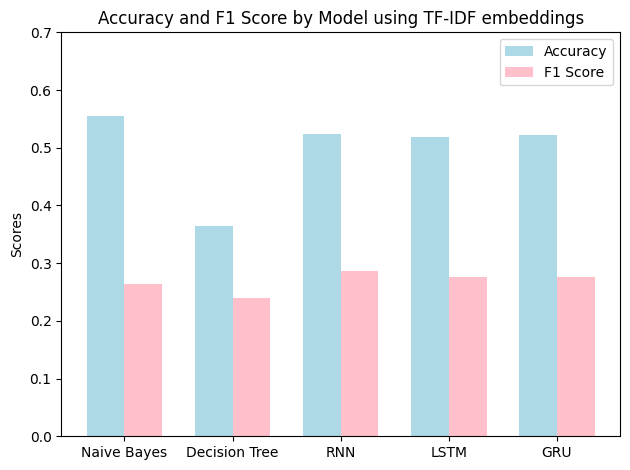

In [ ]:
models = ['Naive Bayes', 'Decision Tree', 'RNN', 'LSTM', 'GRU']
accuracies = [accuracy_NB, accuracy_DT, accuracy_RNN, accuracy_LSTM, accuracy_GRU]
f1_scores = [f1_NB, f1_DT, f1_RNN, f1_LSTM, f1_GRU]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy',color='lightblue')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score',color='pink')

ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Score by Model using TF-IDF embeddings')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.set_ylim(0,0.7)
fig.tight_layout()
plt.show()